# Ukrainian Name Entity Recognition based on BERT

In [0]:
## training based on paper -- https://mccormickml.com/2019/07/22/BERT-fine-tuning/

**Installing needed packages**

In [0]:
# !pip install pytorch_pretrained_bert
# !pip install torch
# !pip install transformers
# !pip install seaborn
# !pip install sklearn

In [0]:
import torch

device = torch.device("cpu")

## Data preprocessing

---

In [18]:
import pandas as pd
## tokens.tok.ann -- merged table of data, that we have found here -- 
## https://github.com/lang-uk/ner-uk/tree/master/data
data = pd.read_csv("data/tokens.tok.ann", delimiter='\t')

data

,T,label,entity
0,T1,ОРГ 91 109,Київський велотрек
1,T2,ОРГ 110 141,Київський велотрек « Авангард »
2,T3,ЛОК 145 179,вул . Богдана Хмельницького 58-А
3,T4,ОРГ 513 548,Шевченківської райдержадміністрації
4,T5,ПЕРС 549 560,Олег Гаряга
...,...,...,...
7442,T70,ПЕРС 10520 10525,Колею
7443,T71,ПЕРС 10807 10811,Коля
7444,T72,ПЕРС 10991 10996,Маріо
7445,T73,ПЕРС 11089 11093,Коля


In [0]:
# Extracting column 'labels' to three columns
data = data.join(data['label'].str.split(' ', expand=True).add_prefix('lab').fillna('O'))

In [20]:
# Replacing ukrainian types to more common (in pure data both variants are)
data.replace(['ЛОК', 'ОРГ', 'ПЕРС', 'РІЗН'], ['LOC', 'ORG', 'PERS', 'MISC'], inplace=True)
data

,T,label,entity,lab0,lab1,lab2
0,T1,ОРГ 91 109,Київський велотрек,ORG,91,109
1,T2,ОРГ 110 141,Київський велотрек « Авангард »,ORG,110,141
2,T3,ЛОК 145 179,вул . Богдана Хмельницького 58-А,LOC,145,179
3,T4,ОРГ 513 548,Шевченківської райдержадміністрації,ORG,513,548
4,T5,ПЕРС 549 560,Олег Гаряга,PERS,549,560
...,...,...,...,...,...,...
7442,T70,ПЕРС 10520 10525,Колею,PERS,10520,10525
7443,T71,ПЕРС 10807 10811,Коля,PERS,10807,10811
7444,T72,ПЕРС 10991 10996,Маріо,PERS,10991,10996
7445,T73,ПЕРС 11089 11093,Коля,PERS,11089,11093


In [0]:
entities = [str(x) for x in data.entity.values]
labels = data.lab0.values

## Tokenization & Input Formatting

---

In [22]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [23]:
example_text = 'data/A_alumni.krok.edu.ua_Prokopenko_Vidrodzhennia_velotreku(5).tok.txt'

with open(example_text, 'r') as infile:
    random_text = infile.read().split('.')[0]

# Print the original sentence.
print(' Original: ', random_text)

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(random_text))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(random_text)))

 Original:  Історія змін 
Tokenized:  ['Історія', 'з', '##мін']
Token IDs:  [92237, 548, 44591]


### Required formatting

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for ent in entities:
    encoded_sent = tokenizer.encode(
                        ent,
                        add_special_tokens = True)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', entities[0])
print('Token IDs:', input_ids[0])

Original:  Київський велотрек
Token IDs: [101, 32731, 12934, 543, 42714, 46672, 15768, 102]


In [25]:
# Encode labels to some numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for lab in labels:
    if type(lab) != str:
        print('{}: {}'.format(lab, type(lab)))
num_labels = le.fit_transform(labels)
print('Number of labels: {}'.format(len(le.classes_)))

Number of labels: 5


### Padding & truncating

In [26]:
# This tokenizer extrated to to many of tokens. This increases time of training way to much
print('Max sentence length: ', max([len(ent) for ent in input_ids]))

Max sentence length:  98


In [27]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

Using TensorFlow backend.


In [0]:
# Create attention masks
attention_masks = []

for ent in input_ids:
    att_mask = [int(token_id > 0) for token_id in ent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

## Split into training set & testing set.

---



In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 80% for training and 20% for validation.
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, num_labels, 
                                                            random_state=2020, test_size=0.2)
# Do the same for the masks.
train_masks, val_masks, _, _ = train_test_split(attention_masks, num_labels,
                                             random_state=2020, test_size=0.2)

# Split validation data for prediction evaluating
validation_inputs, prediction_inputs, validation_labels, prediction_labels = train_test_split(
    val_inputs, val_labels, random_state = 2020, test_size = 0.2)

# Same for masks
validation_masks, prediction_masks, _, _ = train_test_split(
    val_masks, val_labels, random_state = 2020, test_size = 0.2)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Get the pre-trained model 

Using a pre-trained model allows us to have a decent stating point for our model (used insdead of random initial parameters), impying the task it is used for is quite similar. Here we import a multilingual BERT token-classification model (used for NER) from PyTorch lib. A pre-trained model can also be downloaded from Google AI's official repo https://github.com/google-research/bert, and then set up with config file from the archive. However the Transformers wrapper library provides a convenient importability of this model in PyTorch and TensorFlow.

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

## Train our model

---

In [33]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

### Optimizer & Learning Rate Scheduler

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = num_labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [38]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    187.    Elapsed: 0:22:33.
  Batch    80  of    187.    Elapsed: 0:45:02.
  Batch   120  of    187.    Elapsed: 1:07:29.
  Batch   160  of    187.    Elapsed: 1:30:03.

  Average training loss: 0.57
  Training epcoh took: 1:44:47

Running Validation...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


  Accuracy: 0.00
  Validation took: 0:06:12

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    187.    Elapsed: 0:22:29.
  Batch    80  of    187.    Elapsed: 0:44:51.
  Batch   120  of    187.    Elapsed: 1:07:17.
  Batch   160  of    187.    Elapsed: 1:29:48.

  Average training loss: 0.30
  Training epcoh took: 1:44:28

Running Validation...
  Accuracy: 0.00
  Validation took: 0:06:13

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    187.    Elapsed: 0:22:28.
  Batch    80  of    187.    Elapsed: 0:45:01.
  Batch   120  of    187.    Elapsed: 1:07:36.
  Batch   160  of    187.    Elapsed: 1:30:00.

  Average training loss: 0.21
  Training epcoh took: 1:44:43

Running Validation...
  Accuracy: 0.00
  Validation took: 0:06:13

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    187.    Elapsed: 0:22:29.
  Batch    80  of    187.    Elapsed: 0:45:02.
  Batch   120  of    187.    Elapsed: 1:07:35.
  Batch   160  of    187.    Elapsed: 1:30:05.

  Av

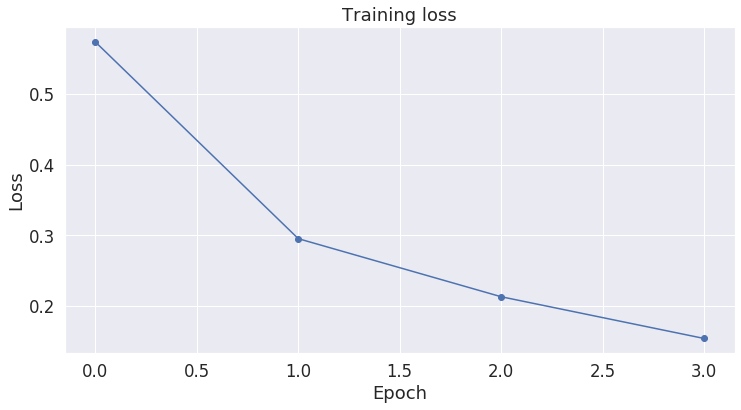

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Performance on the test set

---

## Data preparation

In [0]:
# Set the batch size.  
batch_size = 32  

# Convert to tensors.
prediction_inputs = torch.tensor(prediction_inputs)
prediction_masks = torch.tensor(prediction_masks)
prediction_labels = torch.tensor(prediction_labels)

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Evaluate on test set

In [41]:
# Prediction on test set

print('Predicting labels for {:,} test entities...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 298 test entities...
    DONE.


In [45]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

print (matthews_set)

Calculating Matthews Corr. Coef. for each batch...
[0.847268136874944, 0.8190491048523315, 0.7039215993116904, 0.6377809823754601, 0.884727610829512, 0.9057901234443501, 0.8853046594982079, 0.938615701630471, 0.8469901550953809, 0.7838686930074691]


## Saving model

---

In [46]:
import os

output_dir = './ua_ner_model/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./ua_ner_model/


('./ua_ner_model/vocab.txt',
 './ua_ner_model/special_tokens_map.json',
 './ua_ner_model/added_tokens.json')